# word embedding/词嵌入
    我们用tensorflow来完成一个word2vec的词向量生成，同时可以在Tensorboard中很方便地查看生成的词向量分布.本节中我们将主要使用Skip-Gram模式的Word2Vec。
    
    以“the quick brown fox jumped over the lazy dog"这句话为例。我们要构造一个语境与目标词汇的映射关系，其中语境包括一个单词左边和右边的词汇，假设我们的滑窗尺寸为1，可以制造的映射关系包括[the,brown]->quick、[quick,fox]->brown、[brown,jumped]->fox等。因为skip-gram模型的从目标词汇预测语境，所以训练样本不再是[the,brown]->quick,而是quick->the和quick->brown。我们的数据集就变为了（quick,the）、（quick，brown）、（brown，quick）、（brown ，fox）等。
    
    我们训练时，希望模型能从目标词汇quick预测出语境the，同进也需要制造随机的词汇作为负样本（噪音），我们希望预测的概率分布在正样本the上尽可能大，而在随机产生的负样本上尽可能小。这里的做法就是通过优化算法比如SGD来更新模型中Word Embedding的参数，让概率分布的损失函数（NCE Loss）尽可能小。这样每个单词的Embedded Vector就会随着训练过程不断调整，直到处于一个最适合语料的空间位置。这样我们的损失函数最小，最符合语料，同时预测出正确单词的概率也最高。

## Step 1:环境设定

In [3]:
import tensorflow as tf
import collections
import math
import os
import random
import zipfile
import numpy as np
import urllib
from six.moves import xrange  

In [4]:
%config ZMQInteractiveShell.ast_node_interactivity='all'   # nootbook使用

## Step 2: Download the data.
使用urllib.request.urlretrieve下载数据的压缩文件并核对文件尺寸，如果已经下载了文件则跳过

In [5]:
url = 'http://mattmahoney.net/dc/'
expected_bytes = 31344016
data_folder = 'data/'
file_name = 'text8.zip'

def download(file_name, expected_bytes):
    file_path = data_folder + file_name 
    
    if os.path.exists(file_path):
        print("Dataset ready")
        return file_path
    
    # 使用urllib.request.urlretrieve下载数据的压缩文件
    file_name, _ = urllib.request.urlretrieve(url + file_name, file_path)
    
    # 获取文件相关属性
    file_stat = os.stat(file_path)
    
    # 比对文件的大小是否正确
    if file_stat.st_size == expected_bytes:   # .st_size,以字节为单位的大小
        print('Successfully downloaded the file', file_name)
    else:
        print(file_stat.st_size)
        raise Exception('File ' + file_name +
                        ' might be corrupted. You should try downloading it with a browser.')
    return file_path

file_path = download(file_name, expected_bytes)   # 'data/text8.zip'

Dataset ready


## Step 3: read the data.
解压下载的压缩文件，并使用tf.compat.as_str将数据转成单词的列表。通过程序输出，可以知道数据最后被转为了一个包含17005207个单词的列表。

In [6]:
def read_data(file_path):
    with zipfile.ZipFile(file_path) as f:
#         print(f)             # <zipfile.ZipFile filename='data/text8.zip' mode='r'>
#         print(f.namelist())  # namelist() 返回zip压缩包中的所有文件,list格式：['text8']
        words = tf.compat.as_str(f.read(f.namelist()[0])).split() 
    return words

# 单词表
words = read_data(file_path)
print(words[:5])
print('Data size', len(words))

['anarchism', 'originated', 'as', 'a', 'term']
Data size 17005207


## Step 4: Build the dictionary and replace rare words with UNK token.
接下来创建vocabulary词汇表，我们使用collections.Counter统计单词列表中单词的频数，然后使用most_common方法取top 50000频数的单词作为vocabulary。再创建一个dict，将top 50000词汇的vocabulary放入dictionary中，以便快速查询，Python中dict查询复杂度为O(1)，性能非常好。接下来将全部单词转为编号（以频数排序的编号），top 50000词汇之外的单词，我们认定其为Unkown（未知），将其编号为0，并统计这类词汇的数量。下面遍历单词列表，对其中每一个单词，先判断是否出现在dictionary中，如果是则转为其编号，如果不是则转为编号0（Unkown）。最后返回转换后的编码（data）、每个单词的频数统计（count）、词汇表（dictionary）及其反转的形式（reverse_dictionary）。

In [7]:
vocab_size = 50000
def build_vocab(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocab_size - 1))
    
    # 生成 dictionary，词对应编号, word:id(0-4999),共50000个单词
    # 词频越高编号越小
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
        
    # data把数据集的词都编号（以频数排序的编号）
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  
            unk_count += 1
        data.append(index)
        
    # 记录UNK词的数量
    count[0][1] = unk_count
    
    # 编号对应词的字典：把字典的键和值对换位置
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary    

data, count, dictionary, reverse_dictionary = build_vocab(words)

In [8]:
del words
print('Most common words (+UNK)', count[:5])
print('数据集data(编号形式)',data[:5])
print('reverse_dictionary (编号对应词) ', [reverse_dictionary[i] for i in data[:5]])

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
数据集data(编号形式) [5234, 3081, 12, 6, 195]
reverse_dictionary (编号对应词)  ['anarchism', 'originated', 'as', 'a', 'term']


## Step 5: Function to generate a training batch for the skip-gram model.
    下面生成Word2Vec的训练样本。我们根据前面提到的Skip-Gram模式（从目标单词反推语境），将原始数据"the quick brown fox jumped over the lazy dog"转为（quick ，the）、（quick，brown）、（brown，quick）、（brown,fox）等样本。
    
    我们定义函数generate_batch用来生成训练用的batch数据，参数中batch_size为batch的大小；skip_window指单词最远可以联系的距离，设为1代表只能跟紧邻的两个单词生成样本，比如quick只能和前后的单词生成两个样本（quick，the）和（quick，brown）；num_skips为对每个单词生成多少个样本，它不能大于skip_window值的两倍，并且batch_size必须是它的整数倍（确保每个batch包含了一个词汇对应的所有样本）。我们定义单词序号data_index为global变量，因为我们会反复调用generate_batch，所以要确保data_index可以在函数generate_batch中被修改。我们也使用assert确保num_skips和batch_size满足前面提到的条件。然后用np.ndarray将batch和labels初始化为数组。这里定义span为对某个单词创建相关样本时会使用到的单词数量，包括目标单词本身和它前后的单词，因此span=2*skip_window+1。并创建一个最大容量为span的deque，即双向队列，在对deque使用append方法添加变量时，只会保留最后插入的span个变量。
    
    接下来从序号data_index开始，把span个单词顺序读入buffer作为初始值。因为buffer是容量为span的deque，所以此时buffer已填充满，后续数据将替换掉前面的数据。然后我们进入第一层循环（次数为batch_size//num_skips），每次循环内对一个目标单词生成样本。现在buffer中是目标单词和所有相关单词，我们定义target=skip_window，即buffer中第skip_window个变量为目标单词。然后定义生成样本时需要避免的单词列表 targets_to_avoid，这个列表一开始包括第skip_window个单词（即目标单词），因为我们要预测的是语境单词，不包括目标单词本身。接下来进入第二层循环（次数num_skips），每次循环中对一个语境单词生成样本，先产生随机数，直到随机数不在targets_to_avoid中，代表可以使用的语境单词，然后产生一个样本，feature即目标词汇buffer[skip_window],label则是buffer[target]。同时，因为这个语境单词被使用了，所以再把它添加到targets_to_avoid中过滤。在对一个目标单词生成完成所有样本后（num_skips个样本），我们再读入下一个单词（同时会抛掉buffer中第一个单词），即把滑窗向后移动一位，这样我们的目标单词也向后移动了一个，语境单词也整体后移了，便可以开始生成下一个目标单词的训练样本。两层循环完成后，我们已经获得了batch_size个训练样本，将batch和labels作为函数结果返回。

In [9]:
data_index = 0
def generate_batch(batch_size, num_skips, skip_window):
    """
    这个函数的功能是对数据data中的每个单词，分别与前一个单词和后一个单词生成一个batch，
    即[data[1],data[0]]和[data[1],data[2]]，其中当前单词data[1]存在batch中，前后单词存在labels中
        batch_size:一个batch的大小
        num_skips：对每个单词生成多少个样本
        skip_window:单词最远可以联系的单词，如果为1，前后各一个单词。
    """
    global data_index                          # 全局索引，在data中的位置
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    # 建一个batch大小的数组，保存任意单词
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    # 建一个（batch，1）大小的二位数组，保存任意单词的前一个或者后一个单词，从而形成一个pair
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32) 
    
    # span为对某个单词创建相关样本时会使用到的单词数量
    span = 2 * skip_window + 1  
    
    # 建一个结构为双向队列的缓冲区，大小不超过3
    buffer = collections.deque(maxlen=span)
    
    # 把span个单词顺序读入buffer作为初始值
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    
    print(buffer)
    # 获取batch和labels
    for i in range(batch_size // num_skips):
        # 每次循环内对一个目标单词生成样本
        target = skip_window    # buffer中第skip_window个变量为目标单词
        targets_to_avoid = [skip_window]
        
        # 循环2次，一个目标单词对应两个上下文单词
        for j in range(num_skips):
            while target in targets_to_avoid:
                # 可能先拿到前面的单词也可能先拿到后面的单词
                target = random.randint(0, span - 1)#这里是从0,1,2中随机取一个，它包含两端的值
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

# 调用generate_batch函数简单测试一下其功能
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]],
          '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

deque([5234, 3081, 12], maxlen=3)
3081 originated -> 5234 anarchism
3081 originated -> 12 as
12 as -> 3081 originated
12 as -> 6 a
6 a -> 12 as
6 a -> 195 term
195 term -> 6 a
195 term -> 2 of


## Step 6: 超参数设定.

训练时的batch_size为128；embedding_size为128，embedding_size即将单词转为稠密向量 的维度，一般是50~1000这个范围内的值，这里使用128作为词向量的维度；skip_window即前面提到的单词间最远可以联系的距离，设为1；num_skips即对每个目标单词提取的样本数，设为2。然后我们再生成验证数据valid_examples，这里随机抽取一些频数最高的单词，看向量空间上跟它们最近的单词是否相关性比较高。valid_size=16指用来抽取的验证单词数，valid_window=100是指验证单词只从频数最高的100个单词中抽取，我们使用np.random.choice函数进行随机抽取。而num_sampled是训练时用来做负样本的噪声单词的数量。

In [10]:
batch_size = 128
embedding_size = 128   # 词向量的维度
skip_window = 1        # 单词间最远可以联系的距离
num_skips = 2          # 对每个目标单词提取的样本数

valid_size = 16        # 用来抽取的验证单词数
valid_window = 100     # 验证单词只从频数最高的100个单词中抽取
# 生成验证数据valid_examples
valid_examples = np.random.choice(valid_window, valid_size, replace=False)  # False表示不可以取相同数字
num_sampled = 64       # 训练时用来做负样本的噪声单词的数量

## Step 7: Build and train a skip-gram model.
    定义SKip-Gram Word2Vec模型的网络结构。我们先创建一个tf.Graph并设置为默认的graph。然后创建训练数据中inputs和labels的placeholder，同时将前面随机产生的valid_examples转为TensorFlow中的constant。
    
    接下来，先使用with tf.device('/cpu:0')限定所有计算在CPU上执行，因为接下来的一些计算操作在GPU上可能还没有实现。
    
    然后使用tf.random_uniform随机生成所有单词的词向量embeddings，单词表大小为50000，向量维度为128，再使用tf.nn.embedding_lookup查找输入train_inputs对应的向量embed。下面使用之前提到的NCE Loss作为训练的优化目标，我们使用tf.truncated_normal初始化NCE Loss中的权重参数nce_weights,并将其nce_biases初始化为0。最后使用tf.nn.nce_loss计算学习出的词向量embedding在训练数据上的loss，并使用tf.reduce_mean进行汇总。
    
    我们定义优化器为SGD，且学习速率为1.0。然后计算嵌入向量embeddings的L2范数nurm,再将embeddings除以其L2范数得到标准化后的normalized_embeddings。再使用tf.nn.embedding_lookup查询验证单词的嵌入向量，并计算验证单词的嵌入向量与词汇表中所有单词的相似性。最后，我们使用tf.global_variables_initializer初始化所有模型参数。

In [11]:
'''Step 7: Build and train a skip-gram model'''
graph = tf.Graph()
with graph.as_default():

    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dateset = tf.constant(valid_examples, dtype=tf.int32)

    with tf.device('/cpu:0'):
        embeddings = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0))  # 生成所有单词的词向量
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)  # 查找train_inputs对应的向量embed
        nce_weights = tf.Variable(tf.truncated_normal([vocab_size, embedding_size],
                                                      stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocab_size]))
        loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                             biases=nce_biases,
                                             labels=train_labels,
                                             inputs=embed,
                                             num_sampled=num_sampled,
                                             num_classes=vocab_size))
        # 定义优化器,学习速率为1.0
        optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
        
        # 计算嵌入向量embeddings的L2范数nurm，L2范数：向量各元素的平方和再开根号
        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
        normalized_embeddings = embeddings / norm
        
        # 计算验证单词的嵌入向量与词汇表中所有单词的相似性
        valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dateset)
        similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
        init = tf.global_variables_initializer()

'Step 7: Build and train a skip-gram model'

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
keep_dims is deprecated, use keepdims instead


## Step 8: Begin training
    定义最大的迭代次数为10万次，然后创建并设置默认的session，并执行参数初始化。在每一步训练迭代中，先使用generate_batch生成一个batch的inputss和labels数据，并用它们创建feed_dict。然后使用session.run()执行一次优化器运算（即一次参数更新）和损失计算，并将这一步训练的loss累积到average_loss。
    
    之后每2000次循环，计算一下平均loss并显示出来
    
    每10000次循环，计算一次验证单词与全部单词的相似度，并将与每个验证单词最相似的8个单词展示出来

In [12]:
num_steps = 1001  # 最大的迭代次数为10万次,考虑到本神较差的cpu，用1001
with tf.Session(graph=graph) as session:
    init.run()
    print('Initialized')

    average_loss = 0
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        # 之后每2000次循环，计算一下平均loss并显示出来
        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            print('Average loss at step', step, ':', average_loss)
            average_loss = 0

        # 每10000次循环，计算一次验证单词与全部单词的相似度，并将与每个验证单词最相似的8个单词展示出来
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                # 根据id拿到对应单词
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8
                # 从大到小排序，排除自己本身，取前top_k个值
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)
    # 训练结束得到的词向量
    final_embeddings = normalized_embeddings.eval()
    
    # 观察前几组单词及其对应的词向量
    for i in range(5):
        print(reverse_dictionary[i], final_embeddings[i])

Initialized
deque([46, 59, 156], maxlen=3)
Average loss at step 0 : 278.01904296875
Nearest to used: independently, hinayana, antiwar, zoe, quasars, realtime, four, abner,
Nearest to can: gnome, emancipated, walley, bundeswehr, ant, xinhua, precipitation, mindfulness,
Nearest to new: verhofstadt, ayn, toluene, aide, sibling, offended, arlene, mehmed,
Nearest to five: hordes, dyke, marini, fallacy, boyhood, melt, wieman, nutshell,
Nearest to if: hitchhikers, fleischer, polluted, joints, cuzco, mips, represented, gravitons,
Nearest to he: caxton, childs, mercer, possessions, empirical, frideric, earldom, heme,
Nearest to known: junius, econometric, thyroxine, einstein, grail, weighing, clique, aquila,
Nearest to these: sudan, march, antisemitism, sundarbans, deniers, compaor, diffraction, expander,
Nearest to history: dinosaurs, rhea, knightly, rhythmic, volvo, risky, marcello, dissipated,
Nearest to state: fujiko, waffen, wwe, und, owning, primarily, tarzan, campylobacter,
Nearest to us

deque([1, 873, 16825], maxlen=3)
deque([11, 8, 10], maxlen=3)
deque([11823, 20, 6644], maxlen=3)
deque([8, 1065, 60], maxlen=3)
deque([17, 1599, 3758], maxlen=3)
deque([10, 8, 91], maxlen=3)
deque([1, 800, 338], maxlen=3)
deque([35, 46, 895], maxlen=3)
deque([7, 3857, 4347], maxlen=3)
deque([733, 4, 9], maxlen=3)
deque([7, 1713, 7], maxlen=3)
deque([18, 1850, 1], maxlen=3)
deque([31, 8486, 279], maxlen=3)
deque([4, 9, 23], maxlen=3)
deque([2982, 895, 443], maxlen=3)
deque([9554, 2, 130], maxlen=3)
deque([1, 2123, 9554], maxlen=3)
deque([1780, 20, 18], maxlen=3)
deque([22, 22, 3], maxlen=3)
deque([33, 1780, 3], maxlen=3)
deque([32, 1497, 124], maxlen=3)
deque([4347, 18278, 194], maxlen=3)
deque([4347, 18278, 3], maxlen=3)
deque([331, 0, 96], maxlen=3)
deque([11823, 2817, 595], maxlen=3)
deque([12, 1, 887], maxlen=3)
deque([1, 1549, 321], maxlen=3)
deque([226, 1, 820], maxlen=3)
deque([4164, 80, 27], maxlen=3)
deque([27, 18, 2807], maxlen=3)
deque([286, 20, 90], maxlen=3)
deque([2638, 26

deque([9, 1574, 2760], maxlen=3)
deque([2760, 1574, 15], maxlen=3)
deque([682, 25, 2760], maxlen=3)
deque([1954, 2, 0], maxlen=3)
deque([3147, 2, 1], maxlen=3)
deque([13, 22, 22], maxlen=3)
deque([19, 497, 7097], maxlen=3)
deque([2301, 252, 2], maxlen=3)
deque([25, 56, 2406], maxlen=3)
deque([6057, 3, 5], maxlen=3)
deque([5, 30, 785], maxlen=3)
deque([228, 1, 52], maxlen=3)
deque([18048, 1195, 3], maxlen=3)
deque([0, 6, 2379], maxlen=3)
deque([402, 11, 87], maxlen=3)
deque([7, 3066, 35], maxlen=3)
deque([2, 2412, 78], maxlen=3)
deque([5218, 30, 578], maxlen=3)
deque([1100, 55, 12], maxlen=3)
deque([674, 24, 0], maxlen=3)
deque([5204, 523, 19], maxlen=3)
deque([574, 80, 1], maxlen=3)
deque([198, 4205, 163], maxlen=3)
deque([17, 16, 490], maxlen=3)
deque([5, 6, 15358], maxlen=3)
deque([2, 1, 29392], maxlen=3)
deque([1050, 898, 49], maxlen=3)
deque([2537, 19234, 3], maxlen=3)
deque([4255, 7, 898], maxlen=3)
deque([754, 156, 3618], maxlen=3)
deque([185, 2055, 1], maxlen=3)
deque([3, 9834, 

deque([8055, 1, 32845], maxlen=3)
deque([123, 2307, 64], maxlen=3)
deque([740, 1751, 35], maxlen=3)
deque([19, 1434, 6285], maxlen=3)
deque([3, 1, 1077], maxlen=3)
deque([13, 13, 16], maxlen=3)
deque([5, 1, 18045], maxlen=3)
deque([742, 120, 65], maxlen=3)
deque([14627, 1225, 5], maxlen=3)
deque([9, 2139, 591], maxlen=3)
deque([2207, 840, 36], maxlen=3)
deque([22, 4, 9], maxlen=3)
deque([4, 9, 21], maxlen=3)
deque([16122, 4, 9], maxlen=3)
deque([9, 16, 22], maxlen=3)
deque([10, 2, 2544], maxlen=3)
deque([201, 12146, 38965], maxlen=3)
deque([895, 3, 934], maxlen=3)
deque([1, 8572, 5], maxlen=3)
deque([256, 12141, 14], maxlen=3)
deque([519, 191, 1], maxlen=3)
deque([94, 6421, 2545], maxlen=3)
deque([26, 3371, 5], maxlen=3)
deque([5915, 10476, 3], maxlen=3)
deque([11, 37, 3007], maxlen=3)
deque([2, 31, 4020], maxlen=3)
deque([37470, 2082, 12072], maxlen=3)
deque([8, 16483, 10], maxlen=3)
deque([16, 10097, 21], maxlen=3)
deque([303, 34, 5], maxlen=3)
deque([25126, 3950, 5226], maxlen=3)
de

In [ ]:
# gpu:最大的迭代次数为10万次
# 第一轮
Average loss at step 0 : 310.89898681640625
Nearest to other: sufficed, prequels, dries, rodents, rat, uppermost, shaykh, ohms,
Nearest to many: quinn, celebes, attends, fulham, anxieties, endorsed, origination, playwrights,
Nearest to only: costanza, verdi, steelers, destroyed, encapsulated, mint, finger, gag,
Nearest to eight: loran, trope, trackball, uni, pirandello, catenary, unwillingness, sibelius,
Nearest to system: unital, sun, selected, symbolized, donau, odour, spanking, framers,
Nearest to its: militia, hitchcock, ichi, topple, ecozone, interdependent, personifications, salim,
Nearest to but: debra, gemstone, justicia, unoccupied, nz, wala, bras, fictionalized,
Nearest to at: contends, poker, desi, safari, assessed, thunderbolt, vorarlberg, newborn,
Nearest to see: tart, lymphocyte, hus, complaint, domino, hiker, yerevan, hallowed,
Nearest to while: hmmwv, krause, fathoms, deceit, mansfield, cavalier, hermetical, retrieve,
Nearest to are: collectivisation, rarest, revolutionize, remoteness, hine, counsellor, swore, jumped,
Nearest to i: commemorated, pac, andronicus, forester, cnn, northeasterly, elective, subregion,
Nearest to s: glossy, takla, aw, bootstrapping, gj, digimon, arthur, imdb,
Nearest to new: istat, wherein, motivations, brewed, sinauer, hitler, illegality, appeasement,
Nearest to UNK: appalachian, journeyman, reminding, tacitus, madness, simplification, albino, infiltrated,
Nearest to with: carps, revoluci, pontifical, upc, jabberwock, whirlwind, alamanni, prohibitive,

# 最后几轮
Average loss at step 92000 : 4.712588558316231
Average loss at step 94000 : 4.613355952143669
Average loss at step 96000 : 4.724640299916268
Average loss at step 98000 : 4.6302049300670625
Average loss at step 100000 : 4.66207720386982
Nearest to other: many, michelob, some, victoriae, evelyn, these, subkey, different,
Nearest to many: some, several, these, all, various, other, dasyprocta, kapoor,
Nearest to only: thibetanus, but, dasyprocta, michelob, sticks, callithrix, agouti, always,
Nearest to eight: seven, nine, six, five, four, three, zero, callithrix,
Nearest to system: systems, marmoset, dasyprocta, symbolized, unital, bogot, occultists, dinar,
Nearest to its: their, his, the, her, pheasants, brigham, abitibi, boutros,
Nearest to but: however, and, dasyprocta, though, callithrix, agouti, or, although,
Nearest to at: in, during, on, thaler, near, within, agouti, under,
Nearest to see: but, nn, complaint, redfern, fundamentalist, vec, agouti, kapoor,
Nearest to while: however, and, gland, when, recitative, michelob, but, microcebus,
Nearest to are: were, have, is, franchisee, be, these, dasyprocta, pheasants,
Nearest to i: we, ii, you, fisheries, t, mishnayot, j, supermassive,
Nearest to s: his, cebus, victoriae, five, callithrix, vivaldi, dasyprocta, recitative,
Nearest to new: anus, soaking, microcebus, ian, trinomial, amo, television, dasyprocta,
Nearest to UNK: dasyprocta, agouti, cl, callithrix, cebus, naaman, michelob, kapoor,
Nearest to with: between, through, within, in, callithrix, by, into, bidding,

## Step 9: Visualize the embeddings
下面定义一个用来可视化Word2Vec效果的函数。

这里low_dim_embs是降维到2维的单词的空间向量，我们将在图表中展示每个单词的位置。我们使用plt.scatter(一般将matplotlib.pyplot命名为plt)显示散点力（单词的位置），并用plt.annotate展示单词本身。同时，使用plt.savefig保存图片到本地文件。

我们使用sklearn.manifold.TSNE实现降维，这里直接将原始的128维的嵌入向量降到2维，再用前面的plot_with_labels函数进行展示。这里只展示词频最高的100个单词的可视化结果

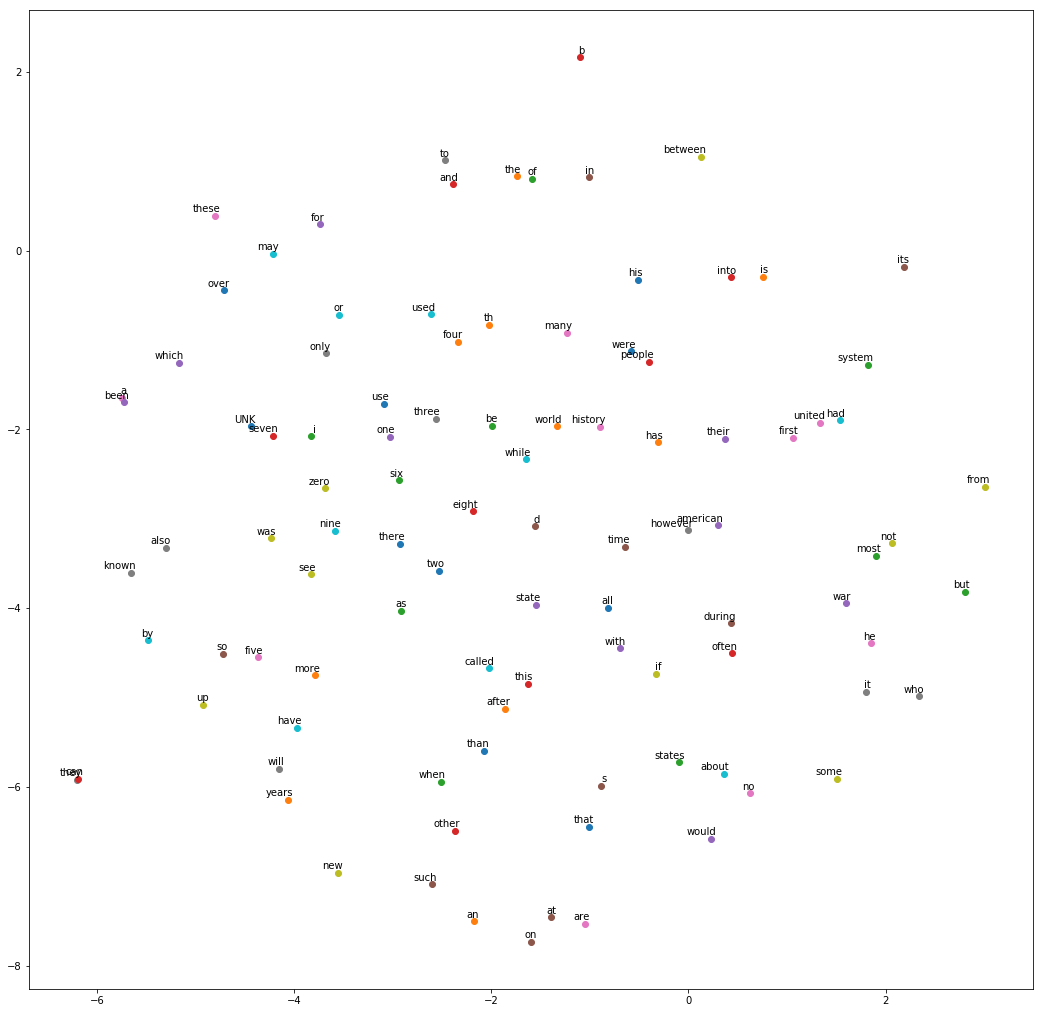

In [14]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    """
    可视化Word2Vec效果的函数
    :param low_dim_embs: 降维到2维的单词的空间向量，将在图表中展示每个单词的位置
    :param labels:词频最高的100个单词
    :param filename: 图片命名
    :return:
    """
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),      # xy设置箭头尖的坐标
                     xytext=(5, 2),  # xytext设置注释内容显示的起始位置
                     textcoords='offset points',  # 设置注释文本的坐标系属性
                     ha='right',
                     va='bottom')

    plt.savefig(filename)


from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

plot_only = 100 # 展示词频最高的100个单词的可视化结果
# 每个词reverse_dictionary对应每个词向量final_embeddings
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

只用了1001次迭代，所以效果不太好。